# Deep Learning Project Derek & Kamiel
## 0) Install and load libraries



In [0]:
!pip install mxnet-cu101==1.6.0b20191122

import mxnet
from mxnet import gluon, npx, np, autograd, gpu
from mxnet.gluon import nn
import os, shutil, zipfile
import skimage.io as io
import matplotlib.pyplot as plt
import pandas as pd
import random
import PIL.Image
import matplotlib
import time
import csv
import mxnet.gluon.data.vision as vision

! pip install d2l -q
import d2l

     |████████████████████████████████| 627.7MB 10kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


## 1) Download the data
This template downloads the UCM data (both mono and multi-labels) in your local Colab environment. Write the notebook in such a way that it fully runs from start to end without further intervention (i.e. do not change the directory structure manually in the mean time).

In [0]:
if not os.path.isdir('ucmdata'):
  ! git clone https://git.wur.nl/lobry001/ucmdata.git
os.chdir('ucmdata')

with zipfile.ZipFile('UCMerced_LandUse.zip', 'r') as zip_ref:
    zip_ref.extractall('UCMImages')

!mv UCMImages/UCMerced_LandUse/Images .
!rm -rf UCMImages README.md  UCMerced_LandUse.zip
!ls

UCM_images_path = "Images/"
Multilabels_path = "LandUse_Multilabeled.txt"

Cloning into 'ucmdata'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 8 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (8/8), done.
Images	LandUse_Multilabeled.txt


In [0]:
## ============== Function to split data paths in train/test for data loading =========================

def convert_and_split(parent_dir, split_ratio = 0.8, n_copies = 0):
    ''' randomly split all filenames in a parent directory into a test and a train set AND copy them to their respective directories
    parent_dir = pathname of the parent directory
    split_ratio = train/test ratio, default of 0.8 will give 80% train, 20% test
    '''
    # walk through the parent dir and find all file paths that are not hidden files
    listOfFiles = list()
    dirs = []
    for root, directories, filenames in os.walk(parent_dir):
        if not dirs: # save a list of class directories
            dirs = directories
        for filename in filenames:
            if not filename.startswith('.'):
                path = os.path.join(root, filename)

                if not path.endswith('.PNG'):
                    im = PIL.Image.open(path)
                    im.save(path.split('.')[0] + '.PNG', 'PNG', quality=100)
                    os.remove(path)
                    path = path.split('.')[0] + '.PNG'
                listOfFiles += [path]

    # Multiply the images
    if n_copies > 0:
        for root, directories, filenames in os.walk(parent_dir):
            # print(root, filenames)
            for filename in filenames:
                src = os.path.join(root, filename)
                base = ''.join(i for i in os.path.basename(src).split('.')[0] if not i.isdigit())
                filenr =  ''.join(i for i in os.path.basename(src).split('.')[0] if i.isdigit())
                ext = ''.join(i for i in os.path.basename(src).split('.')[1])

                for i in range(n_copies):
                    new = root + "/" + base + filenr + str(i) + '.' + ext
                    shutil.copy(src, new)
                    listOfFiles += [new]

    # shuffle list of file paths and split according to the split ratio
    random.shuffle(listOfFiles)

    # create folder structure for test and train data
    for mode in ['train', 'test']:
        if not os.path.exists(mode):
            os.mkdir(mode)
            [os.mkdir(os.path.join(mode, dir)) for dir in dirs]

    for i, path in enumerate(listOfFiles):
        mode = "train" if i < round(len(listOfFiles) * split_ratio) else "test"
        file = os.path.split(path)[1]
        file_dir = ''.join(filter(lambda x: x.isalpha(), file.split('.')[0]))
        os.rename(path, os.path.join(mode, file_dir, file))


convert_and_split(parent_dir = UCM_images_path, n_copies = 5)

## 2) Initialize dataset and data loader

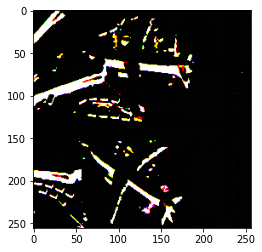

In [0]:
## =============== DEFINING DATA SETS AND LOADERS ==================

train_folder = 'train'
test_folder = 'test'
batch_size = 16


def transformer(data, label, dim=256, ch=3):
  rgb_mean = [0.485, 0.456, 0.406]
  rgb_std = [0.229, 0.224, 0.225]

  trans = vision.transforms.Compose([vision.transforms.CenterCrop(dim),
                                     vision.transforms.RandomFlipLeftRight(),
                                     vision.transforms.RandomFlipTopBottom(),
                                     vision.transforms.RandomColorJitter(brightness=0.4, contrast=0.4, saturation=0.4)
                                     ])
  data = trans(data)
  data = data.transpose(axes=(2, 0, 1))

  normalize = vision.transforms.Normalize(mean=rgb_mean, std=rgb_std)
  data = normalize(data.astype('float32')/255)

  # Fill up data with zeros to shape (3, 256, 256)
  data_filled = mxnet.ndarray.zeros(shape=(ch, dim, dim))
  data_filled[:data.shape[0], :data.shape[1], :data.shape[2]] = data

  return data_filled, label

Dataset_Single_train = gluon.data.vision.datasets.ImageFolderDataset(train_folder, transform=transformer) 

Dataset_Single_test = gluon.data.vision.datasets.ImageFolderDataset(test_folder, transform=transformer)

def render_as_image(a):
    img = a.asnumpy() # convert to numpy array
    img = img.transpose((1, 2, 0))  # Move channel to the last dimension
    img = img.astype(np.uint8)  # use uint8 (0-255)

    plt.imshow(img)
    plt.show()

# 3x256x256
render_as_image(Dataset_Single_train[825][0])


DataLoader_Single_train = gluon.data.DataLoader(Dataset_Single_train,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    last_batch='discard')
DataLoader_Single_test = gluon.data.DataLoader(Dataset_Single_test,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    last_batch='discard')

# Make sure the DataLoader is iterable
# for X, label in DataLoader_Single_train:  
#     print(X, label)
#     break
    # if X.shape[2] != 256 or X.shape[3] != 256:
    #   print(X.shape)
    #   print(label.shape)

#### 2.2) Defining the network
We will simply use the FCN architecture seen during the lecture:

Check the output shape of the network

In [0]:
ctx = d2l.try_all_gpus()

In [0]:
net = nn.Sequential()
net.add(nn.Conv2D(channels=3, kernel_size=5, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),

        nn.Conv2D(channels=32, kernel_size=10, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),

        nn.Conv2D(channels=64, kernel_size=10, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),

        nn.Conv2D(channels=128, kernel_size=5, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),

        nn.Conv2D(channels=256, kernel_size=3, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),

        nn.Flatten(),
        
        nn.Dense(256, activation="relu"),
        nn.Dropout(0.2),
        nn.Dense(128, activation="sigmoid"),
        #nn.Dropout(0.4),
        nn.Dense(21))
net.initialize(init=mxnet.init.Xavier())

# Test the network shapes
X = mxnet.ndarray.random.uniform(shape=(5, 3, 256, 256))
for layer in net:
    X = layer(X)
    print(layer.name, 'output shape:\t', X.shape)

conv0 output shape:	 (5, 3, 252, 252)
pool0 output shape:	 (5, 3, 126, 126)
conv1 output shape:	 (5, 32, 117, 117)
pool1 output shape:	 (5, 32, 58, 58)
conv2 output shape:	 (5, 64, 49, 49)
pool2 output shape:	 (5, 64, 24, 24)
conv3 output shape:	 (5, 128, 20, 20)
pool3 output shape:	 (5, 128, 10, 10)
conv4 output shape:	 (5, 256, 8, 8)
pool4 output shape:	 (5, 256, 4, 4)
flatten0 output shape:	 (5, 4096)
dense0 output shape:	 (5, 256)
dropout0 output shape:	 (5, 256)
dense1 output shape:	 (5, 128)
dense2 output shape:	 (5, 21)


In [0]:
# push net to gpu
net.collect_params().initialize(force_reinit=True, ctx=ctx)

In [0]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01, 'momentum': 0.5})

In [0]:
def acc(output, label):
    # output: (batch, num_output) float32 ndarray
    # label: (batch, ) int32 ndarray
    return (output.argmax(axis=1) ==
            label.astype('float32')).mean().asscalar()

In [0]:
num_epochs = 30
train_hist = []

for epoch in range(num_epochs):
    train_loss, train_acc, valid_acc = 0., 0., 0.
    tic = time.time()
    #animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],legend=['train loss', 'train acc', 'test acc'])
    count = 0
    for data, label in DataLoader_Single_train:
      # gpu compatibility
        data = gluon.utils.split_and_load(data, ctx)
        label = gluon.utils.split_and_load(label, ctx)
        # forward + backward
        with autograd.record():
            count += 1
            #if (count % 100 == 0): print(count)
            output = net(mxnet.nd.concat(*data, dim=1)) #unpack the data list
            loss = softmax_cross_entropy(output, label[0]) #index 0 is the actual label
        loss.backward()
        # update parameters
        trainer.step(batch_size)#, ignore_stale_grad=True)
        # calculate training metrics
        train_loss += loss.mean().asscalar()
        train_acc += acc(output, label[0])
        #if (count+1) % 50 == 0: animator.add(epoch + count/len(DataLoader_Single_train),(train_loss, train_acc, None))
    # calculate validation accuracy
    for val_data, val_label in DataLoader_Single_test:
        val_data = gluon.utils.split_and_load(val_data, ctx)
        val_label = gluon.utils.split_and_load(val_label, ctx)
        valid_acc += acc( net(mxnet.nd.concat(*val_data, dim=1) ), val_label[0])
    #animator.add(epoch+1, (None, None, valid_acc))
    hist = "Epoch %d: loss %.3f, train acc %.3f, test acc %.3f, in %.1f sec" % (
            epoch, train_loss/len(DataLoader_Single_train), train_acc/len(DataLoader_Single_train),
            valid_acc/len(DataLoader_Single_test), time.time()-tic)
    train_hist.append(hist)

Epoch 0: loss 2.799, train acc 0.164, test acc 0.258, in 109.8 sec
Epoch 1: loss 2.215, train acc 0.324, test acc 0.380, in 107.8 sec
Epoch 2: loss 1.864, train acc 0.402, test acc 0.391, in 107.2 sec
Epoch 3: loss 1.619, train acc 0.477, test acc 0.510, in 106.7 sec
Epoch 4: loss 1.411, train acc 0.547, test acc 0.511, in 106.5 sec
Epoch 5: loss 1.241, train acc 0.600, test acc 0.637, in 106.2 sec
Epoch 6: loss 1.084, train acc 0.655, test acc 0.691, in 105.8 sec
Epoch 7: loss 0.932, train acc 0.701, test acc 0.676, in 105.6 sec
Epoch 8: loss 0.791, train acc 0.743, test acc 0.781, in 105.9 sec
Epoch 9: loss 0.706, train acc 0.772, test acc 0.793, in 105.5 sec
Epoch 10: loss 0.596, train acc 0.810, test acc 0.845, in 105.5 sec
Epoch 11: loss 0.508, train acc 0.836, test acc 0.868, in 106.1 sec
Epoch 12: loss 0.454, train acc 0.853, test acc 0.881, in 106.0 sec
Epoch 13: loss 0.396, train acc 0.872, test acc 0.868, in 106.4 sec
Epoch 14: loss 0.336, train acc 0.897, test acc 0.928, in 

In [0]:
# save model parameters to drive
model_file_name = 'net_20200424_0842_mom.params'
net.save_parameters(model_file_name)

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

model_file = drive.CreateFile({'title' : model_file_name})
model_file.SetContentFile(model_file_name)
model_file.Upload()


In [0]:
# write training history to file in drive
filename = 'train_hist.txt'
with open('/content/drive/My Drive/' + filename, 'w') as f:
  for i in train_hist:
        f.write(i + '\n')


FileNotFoundError: ignored

Add a classification layer with the right number of image classes.


In [0]:
 # Determine the test accuracy per class 
 text_labels = ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings',
               'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse',
                'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 
                'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential',
                'storagetanks','tenniscourt']

DataLoader_test = gluon.data.DataLoader(Dataset_Single_test,
                                    batch_size=len(Dataset_Single_test),
                                    last_batch='discard')

# Unpack the dataloader object
X, y = [*DataLoader_test][0]

class_accs = {'class':'accuracy'}
for cls in range(21):
  # Find the indexes for a class
  idx = []
  iteration = 0
  for i in range(len(y)): 
    if y[i].asscalar() == cls:
      idx.append(iteration)
    iteration += 1
      
  # subset all data for a class
  images_for_a_class = gluon.utils.split_and_load(X[idx], ctx)
  labels_for_a_class = gluon.utils.split_and_load(y[idx] , ctx)

  # predict all images from a class
  preds = []
  for x in images_for_a_class:
      x = gluon.utils.split_and_load(x, ctx)
      pred = net(mxnet.nd.concat(*x, dim=1)).argmax(axis=1)
      preds.append(pred.astype('int32'))

  # calculate accuracy and append to dict
  class_acc = sum(preds[0] == cls).asscalar() / len(labels_for_a_class[0])
  print(text_labels[cls], class_acc)
  class_accs[text_labels[cls]] = class_acc.astype(float)


agricultural 0.954954954954955
airplane 0.9821428571428571
baseballdiamond 0.9655172413793104
beach 0.9439252336448598
buildings 1.0
chaparral 1.0
denseresidential 0.8661417322834646
forest 0.9537037037037037
freeway 0.9824561403508771
golfcourse 0.9172413793103448
harbor 1.0
intersection 0.9818181818181818
mediumresidential 0.9421487603305785
mobilehomepark 0.9925925925925926
overpass 0.9769230769230769
parkinglot 0.9911504424778761
river 0.9669421487603306
runway 0.9915254237288136
sparseresidential 0.92
storagetanks 0.952
tenniscourt 0.9576271186440678


In [0]:
# write results to file in drive
with open('/content/drive/My Drive/acc_per_class.csv', 'w') as f:
  for key in class_accs.keys():
        f.write("%s,%s\n"%(key,class_accs[key]))
